In [1]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
from collections import Counter
%matplotlib inline

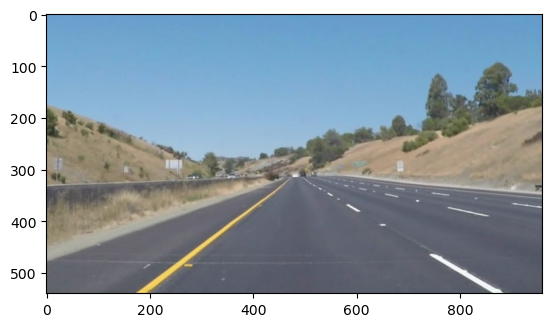

In [2]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

plt.imshow(image)

In [19]:
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
cv.imshow("gray image", gray)
#cv.imwrite()
cv.waitKey(0)


-1

In [23]:
"""
This converts the image from RGB to HSV (Hue, Saturation, Value) color space. 
HSV is often more useful than RGB for color segmentation because it separates the image intensity (Value) from the color information (Hue and Saturation).
"""
hsv_img = cv.cvtColor(image, cv.COLOR_RGB2HSV)
cv.imshow("HSV", hsv_img)
cv.waitKey(0)

-1

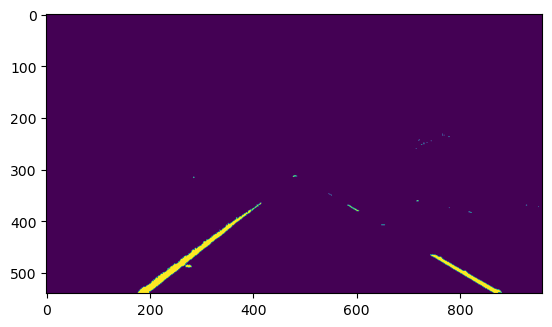

In [8]:
lower_range_y = np.array([20,100,100])
upper_range_y = np.array([30,255,255])
lower_range_w = np.array([0,0,235])
upper_range_w = np.array([255,255,255])

# extract yellow and white part from the image
yellow_part = cv.inRange(hsv_img, lower_range_y, upper_range_y)
white_part = cv. inRange(hsv_img, lower_range_w, upper_range_w)

# masking both extracted images
whole_mask = cv.bitwise_or(yellow_part, white_part)
plt.imshow(whole_mask)

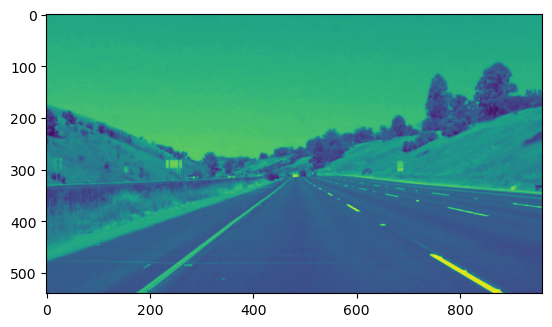

In [9]:
lower_brightness_gray = (gray / 2).astype('uint8')
plt.imshow(lower_brightness_gray)

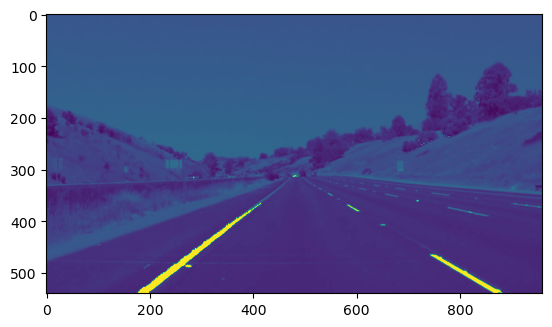

In [10]:
boost_lane = cv.bitwise_or(lower_brightness_gray, whole_mask)
plt.imshow(boost_lane)


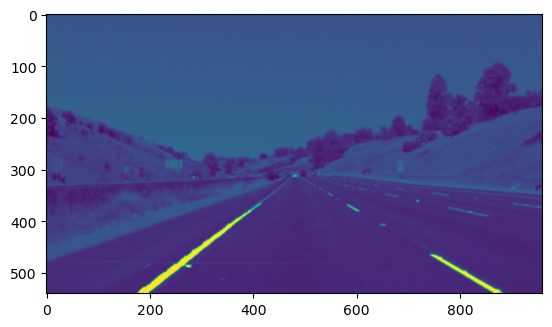

In [11]:
blur_img = cv.GaussianBlur(boost_lane, (5, 5), 0)
plt.imshow(blur_img)

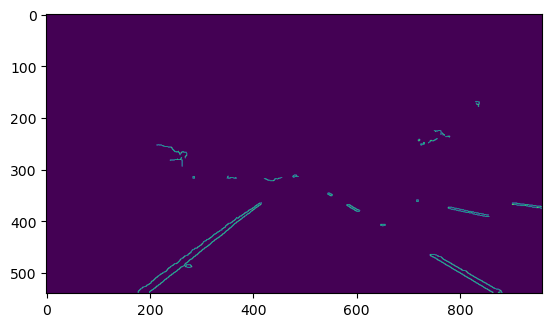

In [12]:
edges = cv.Canny(blur_img, 60, 150)
plt.imshow(edges)

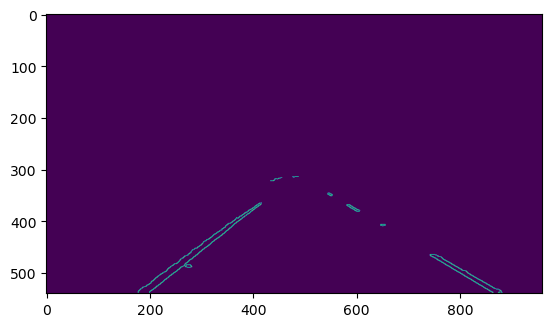

In [13]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv.bitwise_and(img, mask)
    return masked_image

vertices = np.array([[(0, 540), (450,315), (500,315), (960,540)]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges)

In [14]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
   
    slope_lines = []
    intercept_lines = []
    slope_left = []
    slope_right = []
    intercept_left = []
    intercept_right = []
    img_y_size = img.shape[0]
    slope_left_sign = []
    slope_right_sign = []

    # slopes and intercept of all lines
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope_ind = (y2-y1)/(x2-x1) 
            intercept_ind = y1 - x1 * ((y2-y1)/(x2-x1))
            slope_lines.append(slope_ind)
            intercept_lines.append(intercept_ind) 

    for val in slope_lines:
        if val < 0:
            slope_left_sign.append(val)
        else:
            slope_right_sign.append(val)

    mean_slope_left = np.mean(slope_left_sign)
    std_slope_left = np.std(slope_left_sign)
    mean_slope_right = np.mean(slope_right_sign)
    std_slope_right = np.std(slope_right_sign)
    
    for s,i in zip(slope_lines, intercept_lines):
        if abs(s-mean_slope_left) < std_slope_left: 
            slope_left.append(s)
            intercept_left.append(i)
        elif abs(s-mean_slope_right) < std_slope_right:
            slope_right.append(s)
            intercept_right.append(i)

    if len(slope_left) > 0:
        left_line_para = [sum(slope_left)/len(slope_left), sum(intercept_left)/len(intercept_left)]
        left_y1 = int(img_y_size)
        left_x1 = int((left_y1 - left_line_para[1])/ left_line_para[0])
        left_y2 = int(img_y_size * 0.580)
        left_x2 = int((left_y2 - left_line_para[1])/ left_line_para[0])
        cv.line(img, (left_x1, left_y1), (left_x2, left_y2), color, 10)

    if len(slope_right) > 0:
        right_line_para = [sum(slope_right)/len(slope_right), sum(intercept_right)/len(intercept_right)]
        right_y1 = int(img_y_size)
        right_x1 = int((right_y1 - right_line_para[1])/ right_line_para[0])
        right_y2 = int(img_y_size * 0.580)
        right_x2 = int((right_y2 - right_line_para[1])/ right_line_para[0])
        cv.line(img, (right_x1, right_y1), (right_x2, right_y2), color, 10)

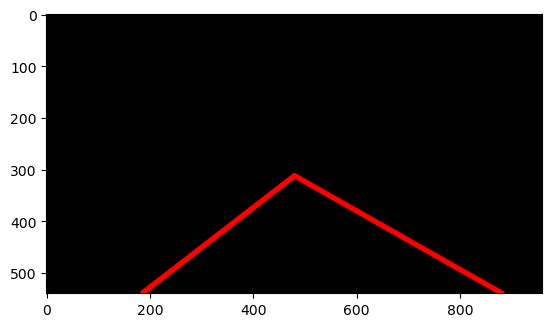

In [15]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines is not None:
        draw_lines(line_img, lines)
    return line_img
rho = 3 # distance resolution in pixels of the Hough grid
theta =  np.pi/180 # angular resolution in radians of the Hough grid
threshold = 40     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 70 #minimum number of pixels making up a line
max_line_gap = 250    # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
color_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(color_edges)

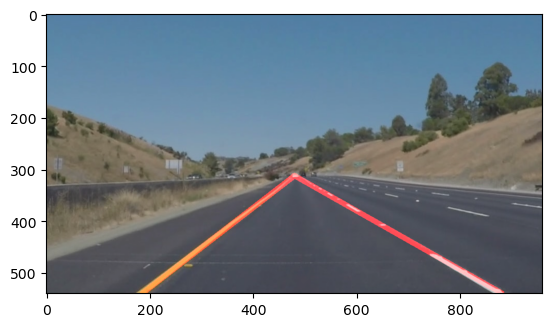

In [16]:

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ (bias)
    NOTE: initial_img and img must be the same shape!
    """
    return cv.addWeighted(initial_img, α, img, β, γ)
line_edge =  weighted_img(color_edges, image)
plt.imshow(line_edge)
#mpimg.imsave('test_images_output/whiteCarLaneSwitch.jpg', line_edge)

In [17]:
def process_image(image):

    #gray scale conversion
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    #hsv image
    hsv_img = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    #range of color in HSV image
    lower_range_y = np.array([20,100,100])
    upper_range_y = np.array([30,255,255])
    lower_range_w = np.array([0,0,235])
    upper_range_w = np.array([255,255,255])

    # extract yellow and white part from the image
    yellow_part = cv.inRange(hsv_img, lower_range_y, upper_range_y)
    white_part = cv. inRange(hsv_img, lower_range_w, upper_range_w)
    whole_mask = cv.bitwise_or(yellow_part, white_part)

    # brightness reduction of gray image 
    lower_brightness_gray = (gray / 2).astype('uint8')

    #boosted image 
    boost_lane = cv.bitwise_or(lower_brightness_gray, whole_mask)

    #gaussian blur
    blur_img = cv.GaussianBlur(boost_lane,(5,5),0)

    # canny edge detection apply
    edges = cv.Canny(blur_img, 60, 150)

    # masked edges 
    vertices = np.array([[(50, 540), (460,310), (500,310), (960,540)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # hough lines
    color_edges = hough_lines(masked_edges, 3, np.pi/180, 40, 70,250)
    # hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)

    # drawing line on edges image
    result =  weighted_img(color_edges, image)
    
    return result

## To compare results with ground truth

In [ ]:
def create_lane_mask_from_lines(shape, lines_img):
    gray_lines = cv.cvtColor(lines_img, cv.COLOR_RGB2GRAY)
    _, binary_mask = cv.threshold(gray_lines, 1, 255, cv.THRESH_BINARY)
    return binary_mask

def calculate_iou(detected_mask, ground_truth_mask):
    intersection = np.logical_and(detected_mask, ground_truth_mask)
    union = np.logical_or(detected_mask, ground_truth_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_precision_recall_f1(detected_mask, ground_truth_mask):
    tp = np.sum(np.logical_and(detected_mask == 255, ground_truth_mask == 255))
    fp = np.sum(np.logical_and(detected_mask == 255, ground_truth_mask == 0))
    fn = np.sum(np.logical_and(detected_mask == 0, ground_truth_mask == 255))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

ground_truth_mask = None

detected_mask = create_lane_mask_from_lines(color_edges.shape, color_edges)

iou = calculate_iou(detected_mask, ground_truth_mask)
precision, recall, f1_score = calculate_precision_recall_f1(detected_mask, ground_truth_mask)

metrics = {
        'IoU': iou,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

print(metrics)